In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 3
DATASET_VERSION = "06"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

1308

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_iterations': 4350,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'max_bin': 63,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 5.996099571922015,
    'lambda_l2': 2.8900783163910697,
    'min_data_in_leaf': 1000,
    'path_smooth': 1.476306537276899,
    'min_gain_to_split': 0.313937968985787,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': True,
    'verbosity': -1,
    # dropout params
    'drop_rate': 0.1,
    'max_drop': 40,
    'skip_drop': 0.7,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
                
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/3 ################################
######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.755192	valid_0's recall_at4: 0.609105	valid_0's norm_gini: 0.901278
[100]	valid_0's amex_metric: 0.765242	valid_0's recall_at4: 0.623454	valid_0's norm_gini: 0.90703
[150]	valid_0's amex_metric: 0.771268	valid_0's recall_at4: 0.631785	valid_0's norm_gini: 0.910752
[200]	valid_0's amex_metric: 0.776692	valid_0's recall_at4: 0.63898	valid_0's norm_gini: 0.914404
[250]	valid_0's amex_metric: 0.781206	valid_0's recall_at4: 0.645544	valid_0's norm_gini: 0.916869
[300]	valid_0's amex_metric: 0.784616	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.918555
[350]	valid_0's amex_metric: 0.787309	valid_0's recall_at4: 0.654759	valid_0's norm_gini: 0.919859
[400]	valid_0's amex_metric: 0.788793	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.920891
[450]	valid_0's amex_metric: 0.789829	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.921574
[500]	valid_0's amex_metric: 0.790553	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.922098
[550]	valid_0

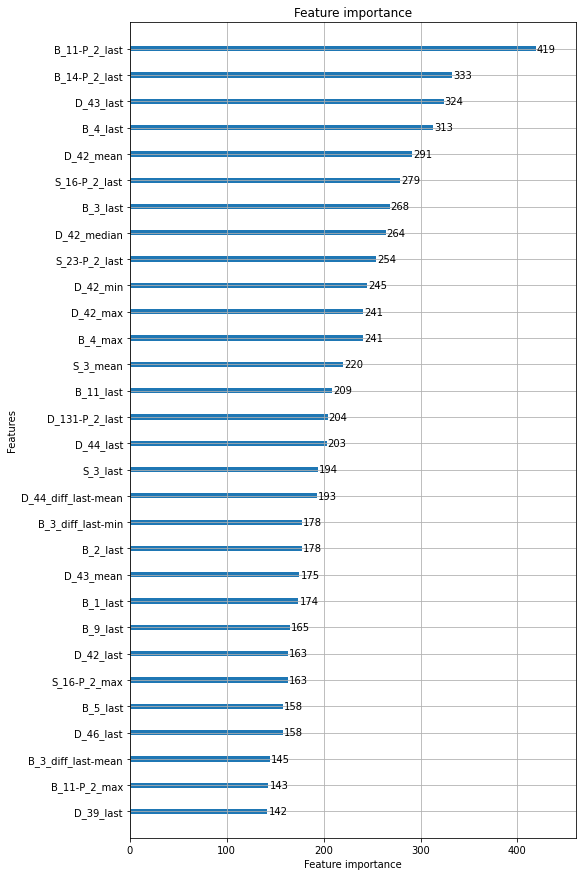

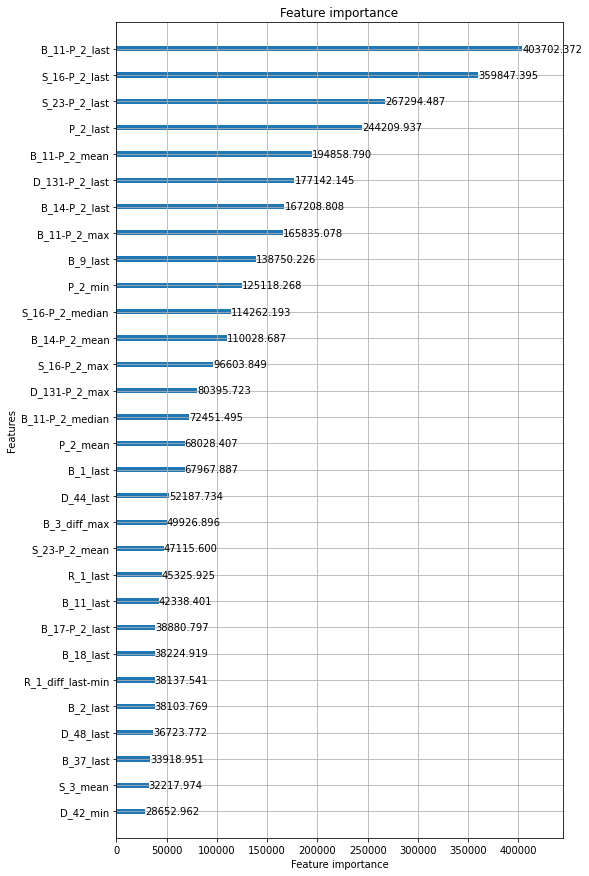

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.748683	valid_0's recall_at4: 0.59724	valid_0's norm_gini: 0.900127
[100]	valid_0's amex_metric: 0.759887	valid_0's recall_at4: 0.614197	valid_0's norm_gini: 0.905577
[150]	valid_0's amex_metric: 0.767168	valid_0's recall_at4: 0.62501	valid_0's norm_gini: 0.909325
[200]	valid_0's amex_metric: 0.773061	valid_0's recall_at4: 0.633131	valid_0's norm_gini: 0.91299
[250]	valid_0's amex_metric: 0.777595	valid_0's recall_at4: 0.639737	valid_0's norm_gini: 0.915453
[300]	valid_0's amex_metric: 0.78172	valid_0's recall_at4: 0.646259	valid_0's norm_gini: 0.91718
[350]	valid_0's amex_metric: 0.784181	valid_0's recall_at4: 0.64992	valid_0's norm_gini: 0.918442
[400]	valid_0's amex_metric: 0.787569	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.919539
[450]	valid_0's amex_metric: 0.78875	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.920259
[500]	valid_0's amex_metric: 0.789566	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.920838
[550]	valid_0's amex

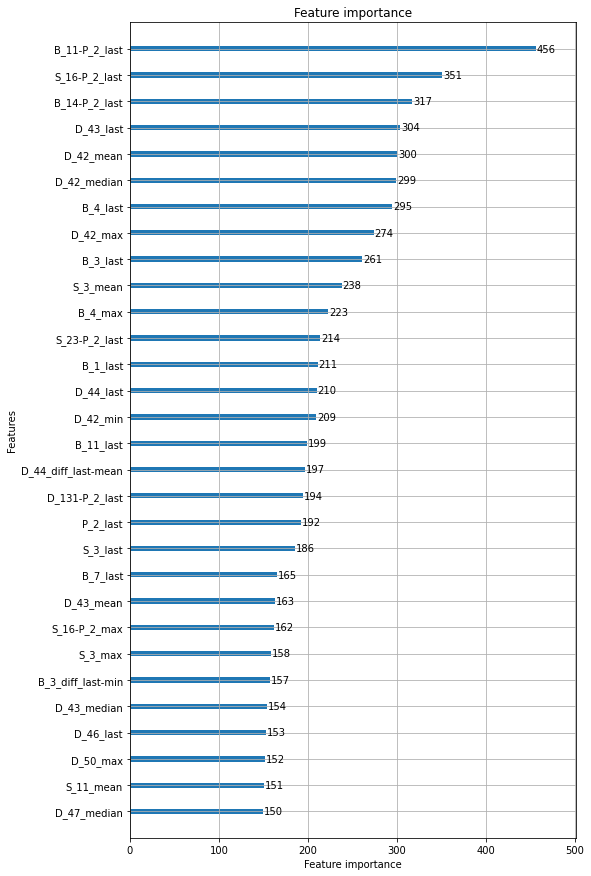

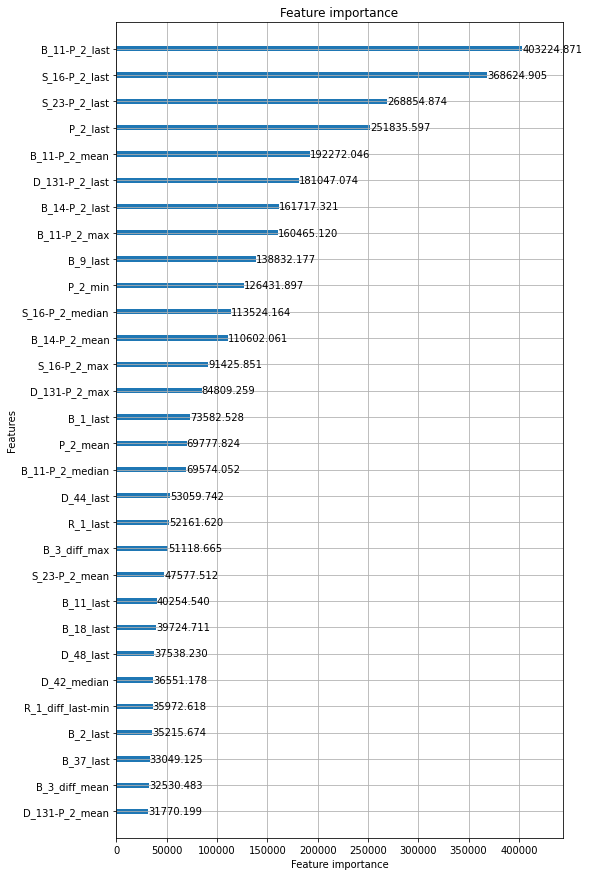

######################################## training model 3/5 ########################################
[50]	valid_0's amex_metric: 0.745467	valid_0's recall_at4: 0.591938	valid_0's norm_gini: 0.898996
[100]	valid_0's amex_metric: 0.755923	valid_0's recall_at4: 0.607128	valid_0's norm_gini: 0.904718
[150]	valid_0's amex_metric: 0.762782	valid_0's recall_at4: 0.617268	valid_0's norm_gini: 0.908296
[200]	valid_0's amex_metric: 0.769191	valid_0's recall_at4: 0.626357	valid_0's norm_gini: 0.912025
[250]	valid_0's amex_metric: 0.773403	valid_0's recall_at4: 0.632374	valid_0's norm_gini: 0.914431
[300]	valid_0's amex_metric: 0.775728	valid_0's recall_at4: 0.63553	valid_0's norm_gini: 0.915927
[350]	valid_0's amex_metric: 0.778731	valid_0's recall_at4: 0.640326	valid_0's norm_gini: 0.917135
[400]	valid_0's amex_metric: 0.782043	valid_0's recall_at4: 0.646007	valid_0's norm_gini: 0.918079
[450]	valid_0's amex_metric: 0.782849	valid_0's recall_at4: 0.646891	valid_0's norm_gini: 0.918807
[500]	vali

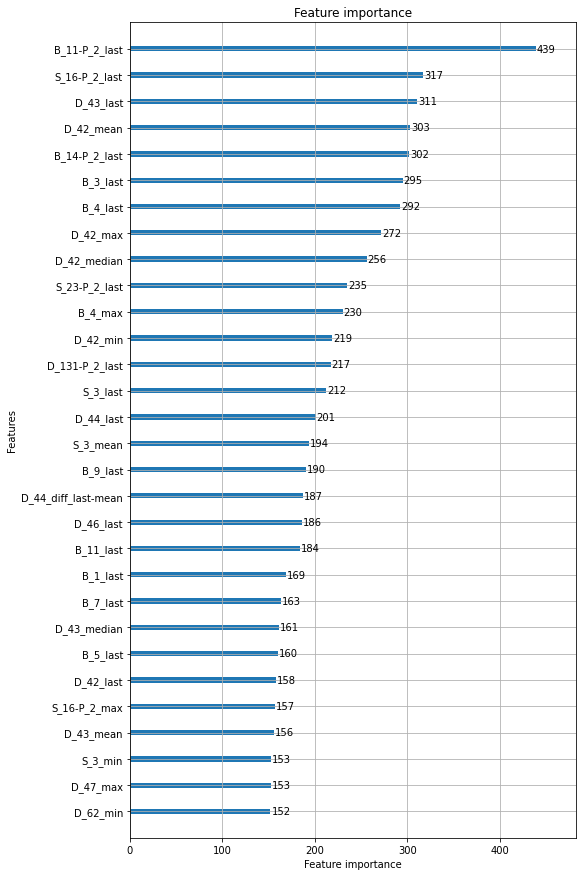

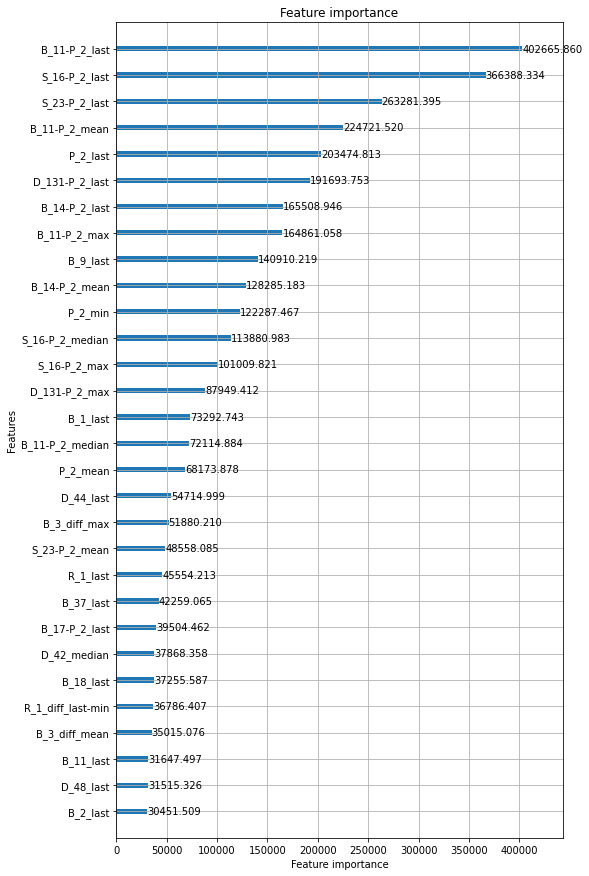

######################################## training model 4/5 ########################################
[50]	valid_0's amex_metric: 0.744491	valid_0's recall_at4: 0.590406	valid_0's norm_gini: 0.898576
[100]	valid_0's amex_metric: 0.755389	valid_0's recall_at4: 0.60648	valid_0's norm_gini: 0.904298
[150]	valid_0's amex_metric: 0.76289	valid_0's recall_at4: 0.617799	valid_0's norm_gini: 0.907981
[200]	valid_0's amex_metric: 0.769354	valid_0's recall_at4: 0.62693	valid_0's norm_gini: 0.911778
[250]	valid_0's amex_metric: 0.773594	valid_0's recall_at4: 0.632863	valid_0's norm_gini: 0.914325
[300]	valid_0's amex_metric: 0.775892	valid_0's recall_at4: 0.635809	valid_0's norm_gini: 0.915975
[350]	valid_0's amex_metric: 0.778427	valid_0's recall_at4: 0.639512	valid_0's norm_gini: 0.917343
[400]	valid_0's amex_metric: 0.780297	valid_0's recall_at4: 0.642247	valid_0's norm_gini: 0.918348
[450]	valid_0's amex_metric: 0.782549	valid_0's recall_at4: 0.646034	valid_0's norm_gini: 0.919065
[500]	valid_

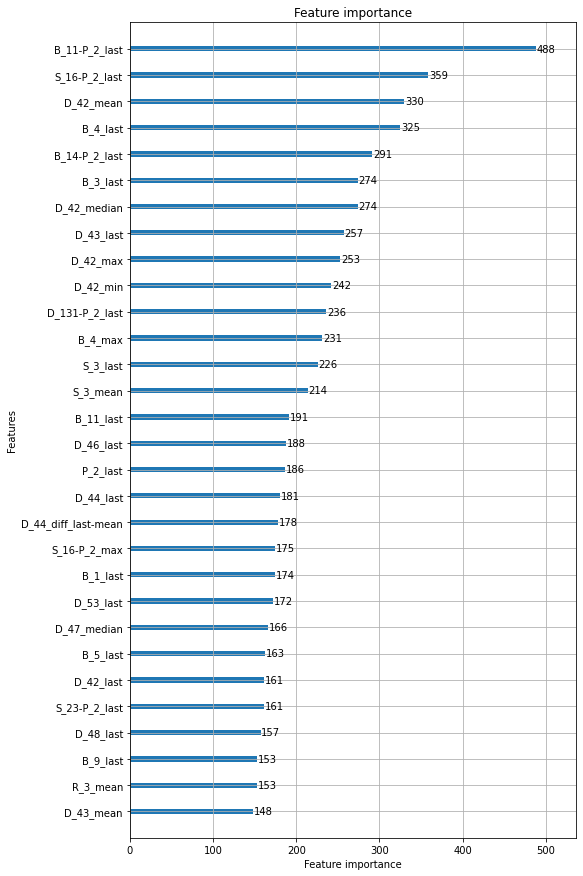

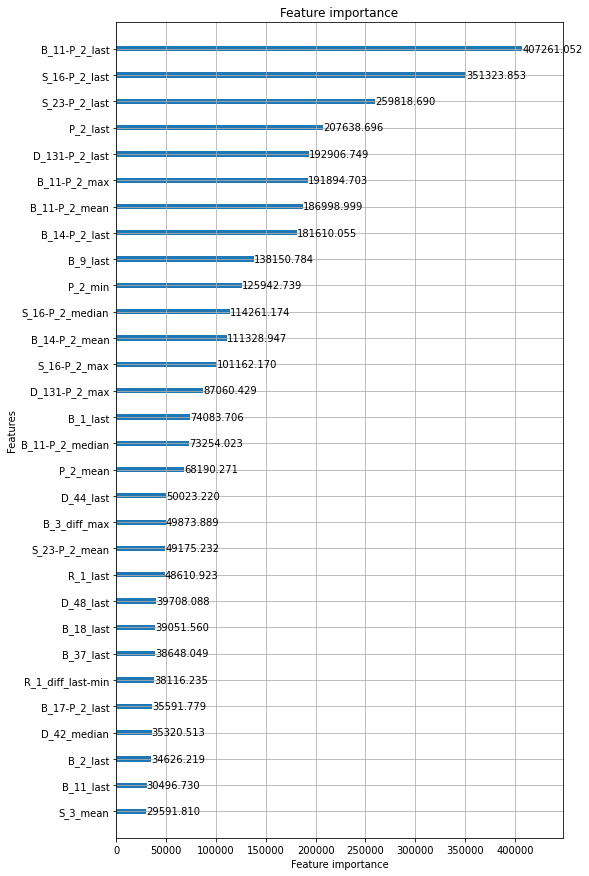

######################################## training model 5/5 ########################################
[50]	valid_0's amex_metric: 0.753705	valid_0's recall_at4: 0.605218	valid_0's norm_gini: 0.902192
[100]	valid_0's amex_metric: 0.763813	valid_0's recall_at4: 0.619735	valid_0's norm_gini: 0.907891
[150]	valid_0's amex_metric: 0.771194	valid_0's recall_at4: 0.630507	valid_0's norm_gini: 0.911882
[200]	valid_0's amex_metric: 0.77825	valid_0's recall_at4: 0.641027	valid_0's norm_gini: 0.915472
[250]	valid_0's amex_metric: 0.782664	valid_0's recall_at4: 0.647423	valid_0's norm_gini: 0.917905
[300]	valid_0's amex_metric: 0.785757	valid_0's recall_at4: 0.652093	valid_0's norm_gini: 0.919421
[350]	valid_0's amex_metric: 0.788538	valid_0's recall_at4: 0.656343	valid_0's norm_gini: 0.920732
[400]	valid_0's amex_metric: 0.789991	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.921703
[450]	valid_0's amex_metric: 0.791125	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.922457
[500]	vali

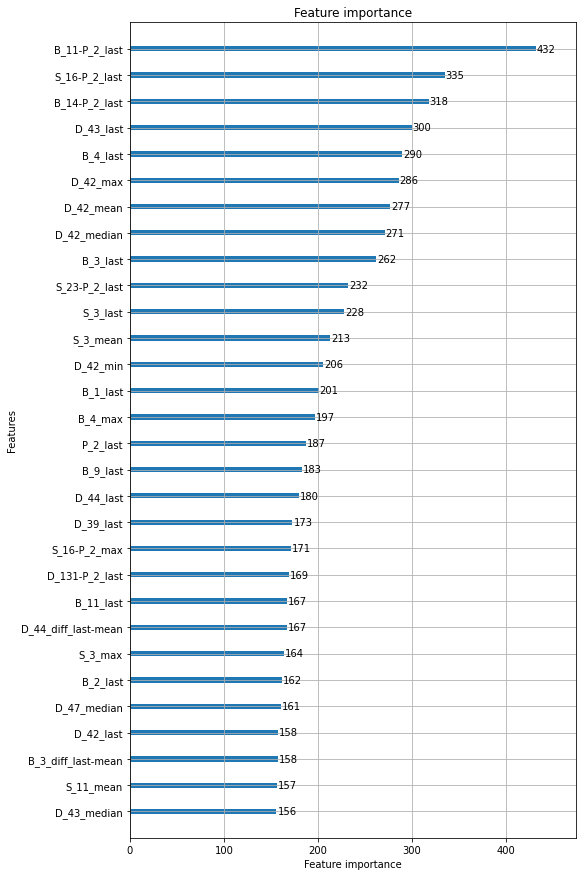

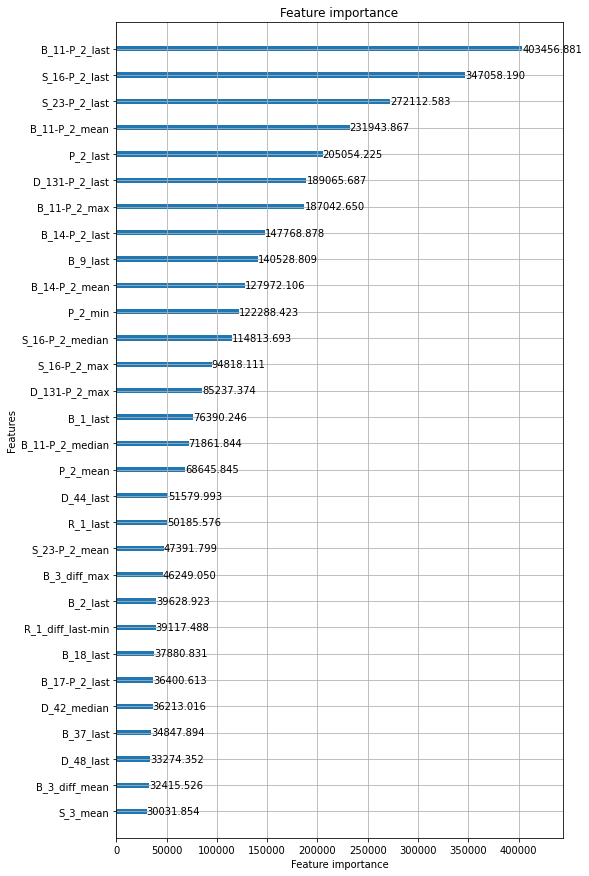

Training time: 85.97270526885987 min.
OOF recall_at4: 0.670574275423301
OOF normalized_gini: 0.9260028299875962
OOF competition metric: 0.7982885527054486
############################### repeated cross-validation step: 2/3 ################################
######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.750739	valid_0's recall_at4: 0.60069	valid_0's norm_gini: 0.900787
[100]	valid_0's amex_metric: 0.763829	valid_0's recall_at4: 0.621055	valid_0's norm_gini: 0.906603
[150]	valid_0's amex_metric: 0.769246	valid_0's recall_at4: 0.628377	valid_0's norm_gini: 0.910115
[200]	valid_0's amex_metric: 0.776309	valid_0's recall_at4: 0.638686	valid_0's norm_gini: 0.913933
[250]	valid_0's amex_metric: 0.780467	valid_0's recall_at4: 0.64445	valid_0's norm_gini: 0.916484
[300]	valid_0's amex_metric: 0.783372	valid_0's recall_at4: 0.648574	valid_0's norm_gini: 0.91817
[350]	valid_0's amex_metric: 0.785859	valid_0's recall_at4: 0.652234	valid_0's norm_gini: 0.919483
[400]	valid_0's amex_metric: 0.788761	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.920533
[450]	valid_0's amex_metric: 0.790516	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.921266
[500]	valid_0's amex_metric: 0.791416	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.921805
[550]	valid_0'

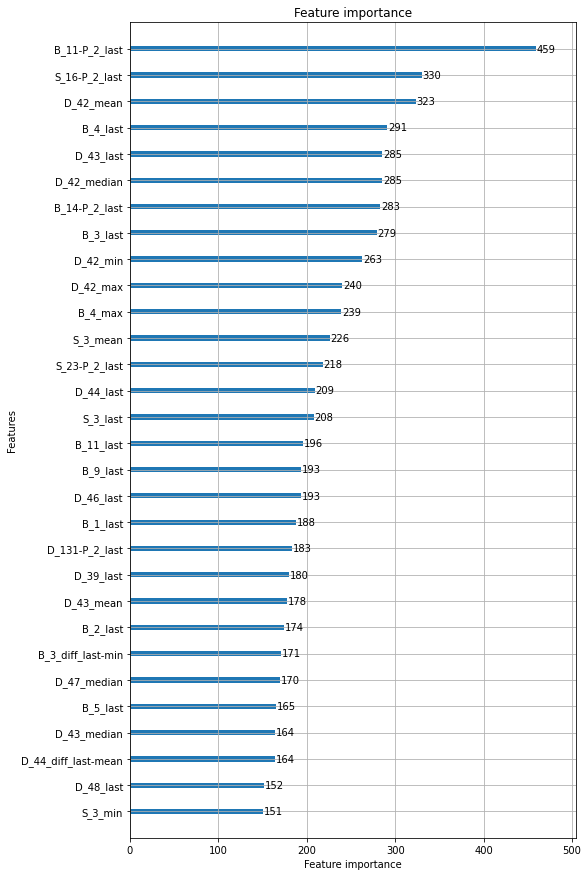

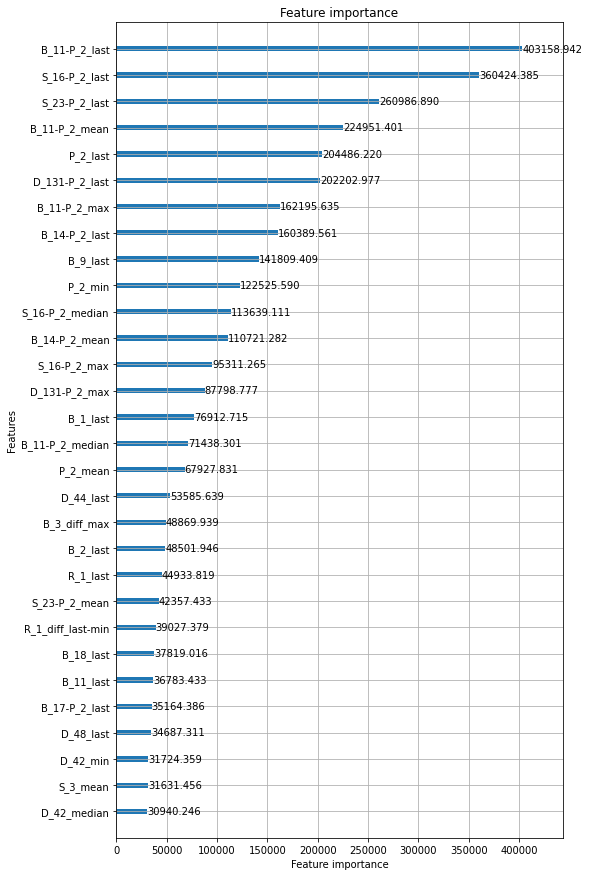

######################################## training model 2/5 ########################################
[50]	valid_0's amex_metric: 0.747598	valid_0's recall_at4: 0.595136	valid_0's norm_gini: 0.900059
[100]	valid_0's amex_metric: 0.75804	valid_0's recall_at4: 0.610536	valid_0's norm_gini: 0.905544
[150]	valid_0's amex_metric: 0.765314	valid_0's recall_at4: 0.621224	valid_0's norm_gini: 0.909404
[200]	valid_0's amex_metric: 0.771759	valid_0's recall_at4: 0.630481	valid_0's norm_gini: 0.913037
[250]	valid_0's amex_metric: 0.775446	valid_0's recall_at4: 0.635488	valid_0's norm_gini: 0.915405
[300]	valid_0's amex_metric: 0.777783	valid_0's recall_at4: 0.638559	valid_0's norm_gini: 0.917007
[350]	valid_0's amex_metric: 0.780364	valid_0's recall_at4: 0.64243	valid_0's norm_gini: 0.918298
[400]	valid_0's amex_metric: 0.782371	valid_0's recall_at4: 0.645418	valid_0's norm_gini: 0.919323
[450]	valid_0's amex_metric: 0.784903	valid_0's recall_at4: 0.649794	valid_0's norm_gini: 0.920012
[500]	valid

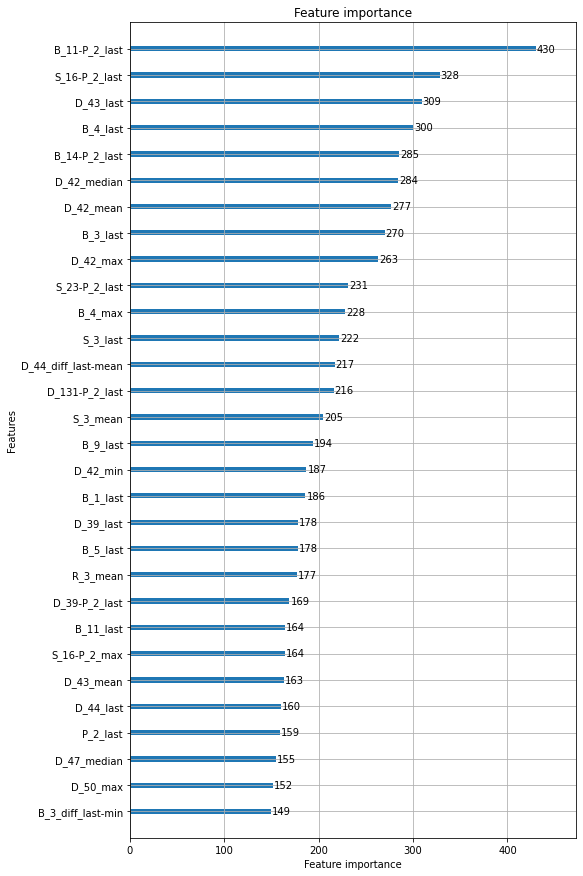

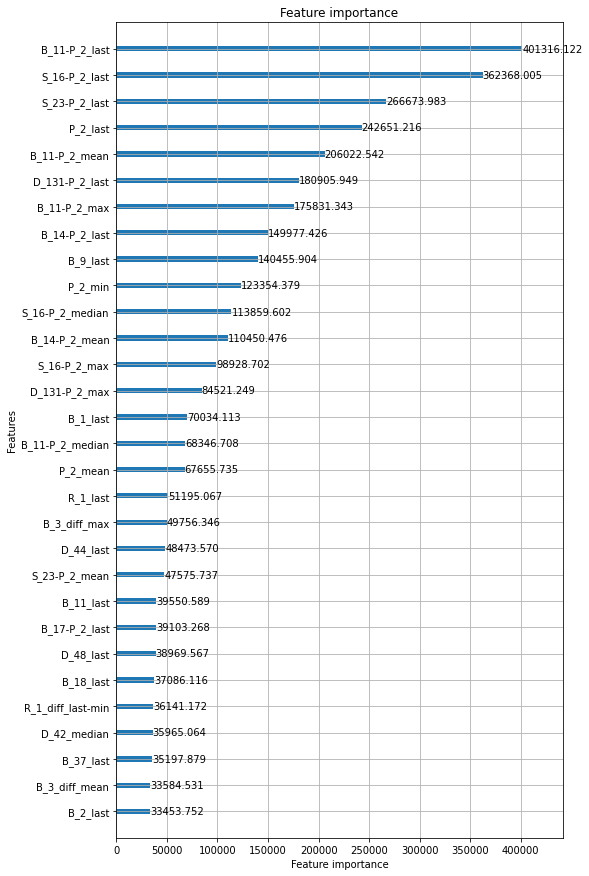

######################################## training model 3/5 ########################################
[50]	valid_0's amex_metric: 0.743402	valid_0's recall_at4: 0.588235	valid_0's norm_gini: 0.898568
[100]	valid_0's amex_metric: 0.75474	valid_0's recall_at4: 0.605319	valid_0's norm_gini: 0.904161
[150]	valid_0's amex_metric: 0.761554	valid_0's recall_at4: 0.615165	valid_0's norm_gini: 0.907944
[200]	valid_0's amex_metric: 0.768039	valid_0's recall_at4: 0.624421	valid_0's norm_gini: 0.911657
[250]	valid_0's amex_metric: 0.77264	valid_0's recall_at4: 0.630985	valid_0's norm_gini: 0.914294
[300]	valid_0's amex_metric: 0.775719	valid_0's recall_at4: 0.635361	valid_0's norm_gini: 0.916077
[350]	valid_0's amex_metric: 0.77918	valid_0's recall_at4: 0.640958	valid_0's norm_gini: 0.917402
[400]	valid_0's amex_metric: 0.780798	valid_0's recall_at4: 0.643104	valid_0's norm_gini: 0.918492
[450]	valid_0's amex_metric: 0.782304	valid_0's recall_at4: 0.645376	valid_0's norm_gini: 0.919233
[500]	valid_

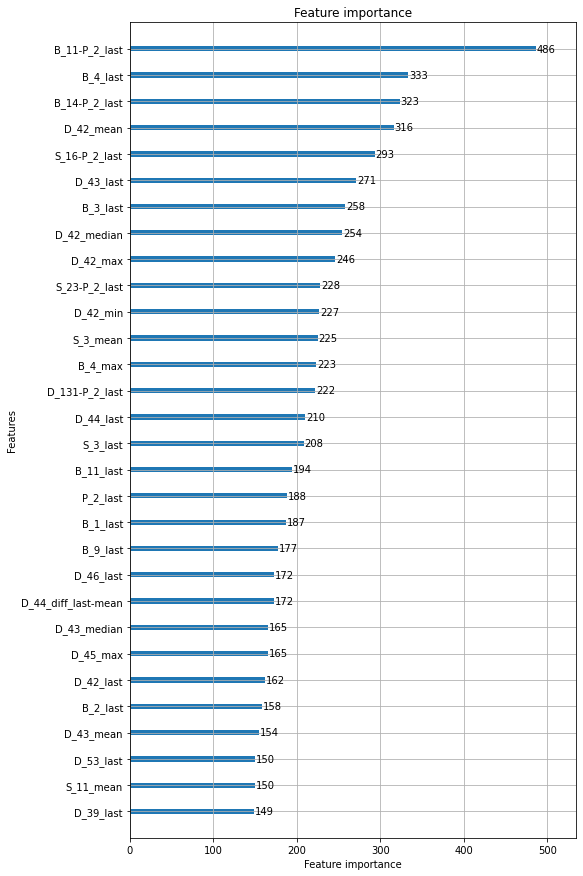

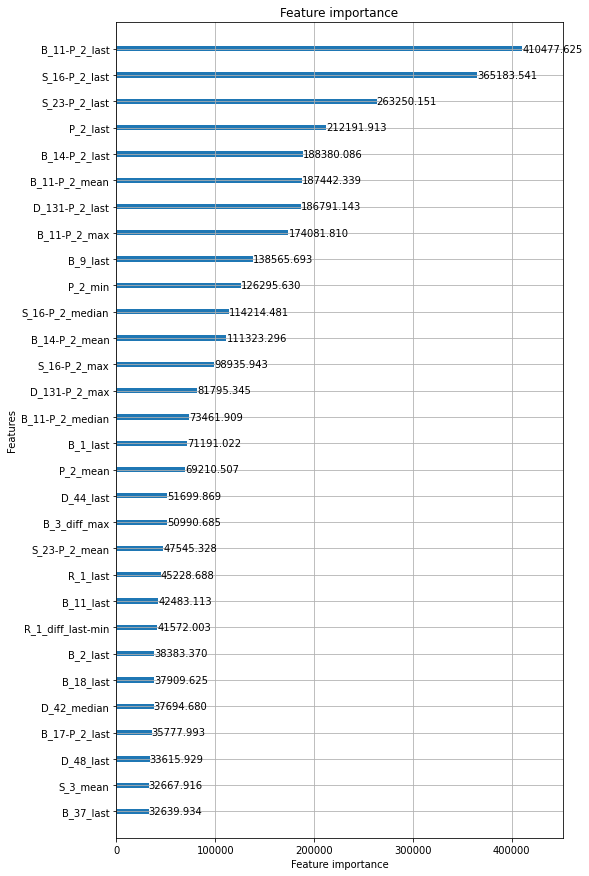

######################################## training model 4/5 ########################################
[50]	valid_0's amex_metric: 0.751084	valid_0's recall_at4: 0.601346	valid_0's norm_gini: 0.900821
[100]	valid_0's amex_metric: 0.762326	valid_0's recall_at4: 0.618136	valid_0's norm_gini: 0.906517
[150]	valid_0's amex_metric: 0.768128	valid_0's recall_at4: 0.626173	valid_0's norm_gini: 0.910084
[200]	valid_0's amex_metric: 0.775837	valid_0's recall_at4: 0.637955	valid_0's norm_gini: 0.913719
[250]	valid_0's amex_metric: 0.780938	valid_0's recall_at4: 0.64574	valid_0's norm_gini: 0.916137
[300]	valid_0's amex_metric: 0.784413	valid_0's recall_at4: 0.651041	valid_0's norm_gini: 0.917784
[350]	valid_0's amex_metric: 0.785806	valid_0's recall_at4: 0.65264	valid_0's norm_gini: 0.918971
[400]	valid_0's amex_metric: 0.788382	valid_0's recall_at4: 0.656806	valid_0's norm_gini: 0.919957
[450]	valid_0's amex_metric: 0.789829	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.920706
[500]	valid

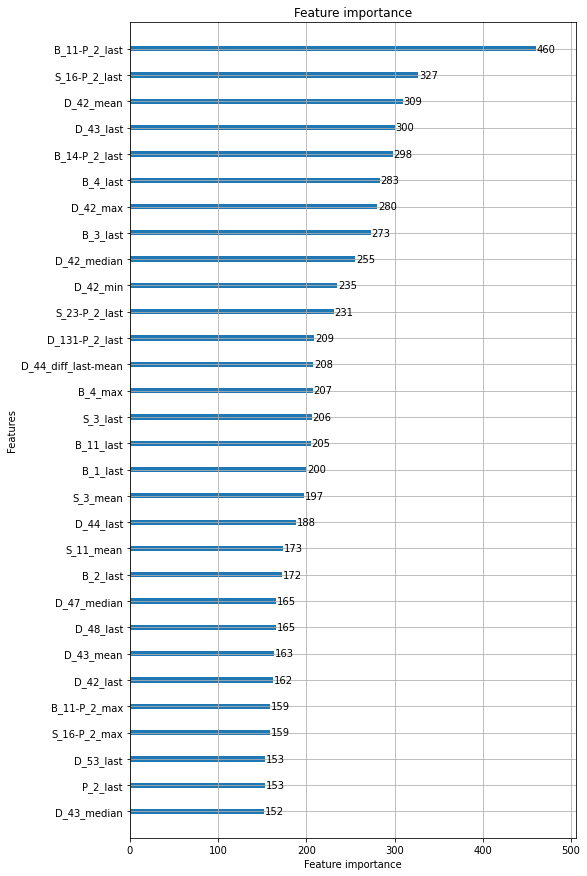

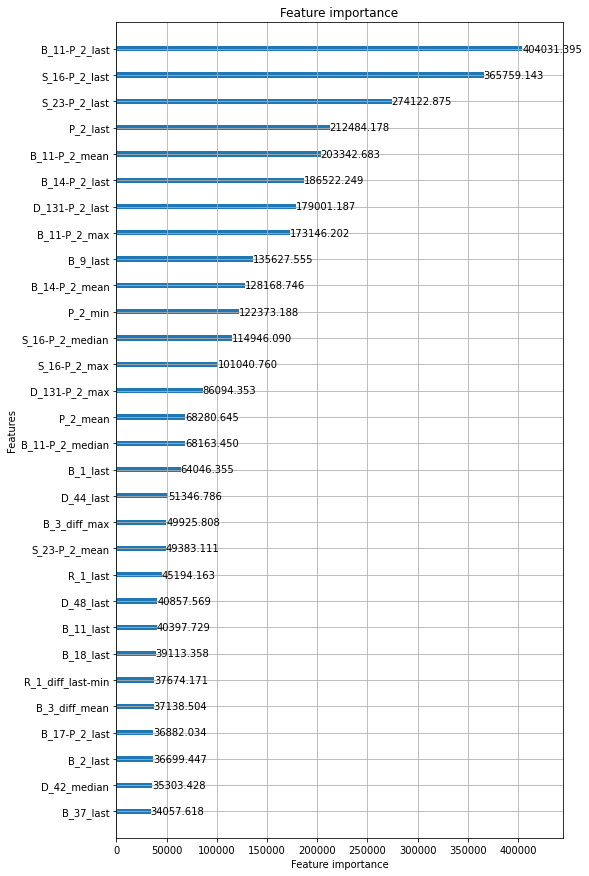

######################################## training model 5/5 ########################################
[50]	valid_0's amex_metric: 0.75121	valid_0's recall_at4: 0.601052	valid_0's norm_gini: 0.901369
[100]	valid_0's amex_metric: 0.762905	valid_0's recall_at4: 0.618767	valid_0's norm_gini: 0.907043
[150]	valid_0's amex_metric: 0.769693	valid_0's recall_at4: 0.628656	valid_0's norm_gini: 0.91073
[200]	valid_0's amex_metric: 0.775705	valid_0's recall_at4: 0.63724	valid_0's norm_gini: 0.914171
[250]	valid_0's amex_metric: 0.778962	valid_0's recall_at4: 0.641447	valid_0's norm_gini: 0.916477
[300]	valid_0's amex_metric: 0.782571	valid_0's recall_at4: 0.647128	valid_0's norm_gini: 0.918014
[350]	valid_0's amex_metric: 0.784125	valid_0's recall_at4: 0.649022	valid_0's norm_gini: 0.919228
[400]	valid_0's amex_metric: 0.786678	valid_0's recall_at4: 0.653145	valid_0's norm_gini: 0.92021
[450]	valid_0's amex_metric: 0.787715	valid_0's recall_at4: 0.654492	valid_0's norm_gini: 0.920937
[500]	valid_0

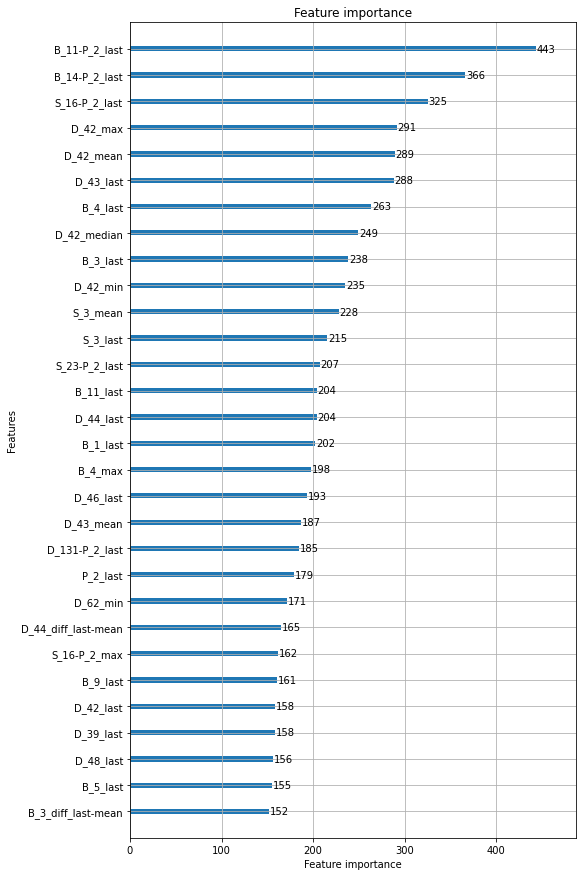

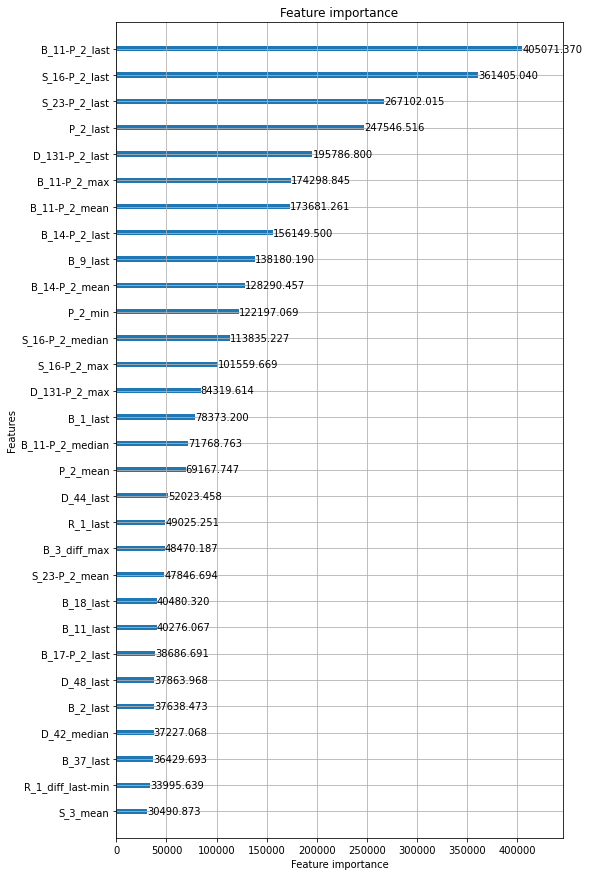

Training time: 86.38827795584997 min.
OOF recall_at4: 0.6715420607937523
OOF normalized_gini: 0.9260529337335056
OOF competition metric: 0.7987974972636289
############################### repeated cross-validation step: 3/3 ################################
######################################## training model 1/5 ########################################
[50]	valid_0's amex_metric: 0.748285	valid_0's recall_at4: 0.597492	valid_0's norm_gini: 0.899078
[100]	valid_0's amex_metric: 0.75847	valid_0's recall_at4: 0.612051	valid_0's norm_gini: 0.904889
[150]	valid_0's amex_metric: 0.764097	valid_0's recall_at4: 0.619625	valid_0's norm_gini: 0.908569
[200]	valid_0's amex_metric: 0.769807	valid_0's recall_at4: 0.627409	valid_0's norm_gini: 0.912206
[250]	valid_0's amex_metric: 0.77538	valid_0's recall_at4: 0.636077	valid_0's norm_gini: 0.914682
[300]	valid_0's amex_metric: 0.777837	valid_0's recall_at4: 0.639359	valid_0's norm_gini: 0.916316
[350]	valid_0's amex_metric: 0.779642	valid_0's rec

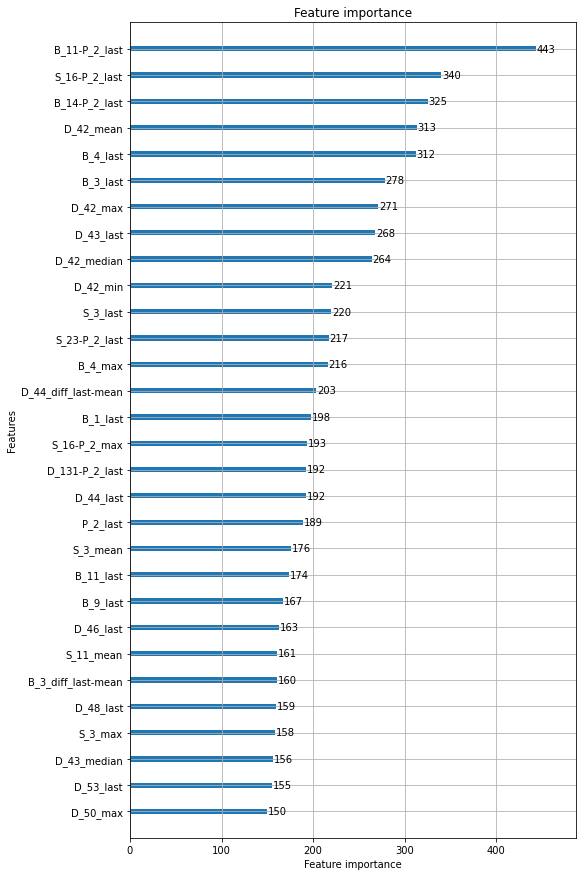

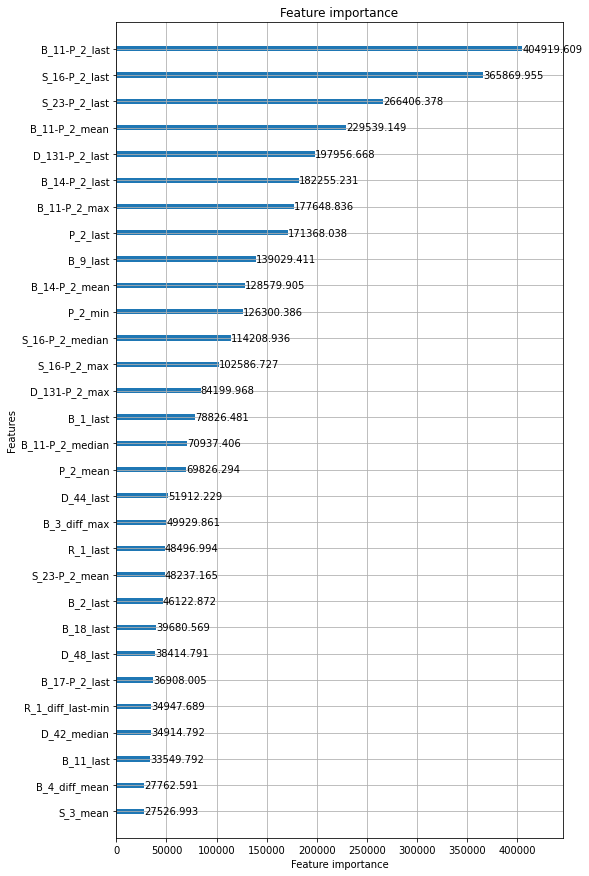

######################################## training model 2/5 ########################################
[50]	valid_0's amex_metric: 0.747	valid_0's recall_at4: 0.593663	valid_0's norm_gini: 0.900336
[100]	valid_0's amex_metric: 0.757228	valid_0's recall_at4: 0.608474	valid_0's norm_gini: 0.905982
[150]	valid_0's amex_metric: 0.763478	valid_0's recall_at4: 0.617437	valid_0's norm_gini: 0.909519
[200]	valid_0's amex_metric: 0.76982	valid_0's recall_at4: 0.626609	valid_0's norm_gini: 0.913031
[250]	valid_0's amex_metric: 0.774417	valid_0's recall_at4: 0.633342	valid_0's norm_gini: 0.915492
[300]	valid_0's amex_metric: 0.777106	valid_0's recall_at4: 0.637044	valid_0's norm_gini: 0.917168
[350]	valid_0's amex_metric: 0.778535	valid_0's recall_at4: 0.638601	valid_0's norm_gini: 0.918469
[400]	valid_0's amex_metric: 0.781719	valid_0's recall_at4: 0.643987	valid_0's norm_gini: 0.919451
[450]	valid_0's amex_metric: 0.783054	valid_0's recall_at4: 0.645923	valid_0's norm_gini: 0.920185
[500]	valid_0

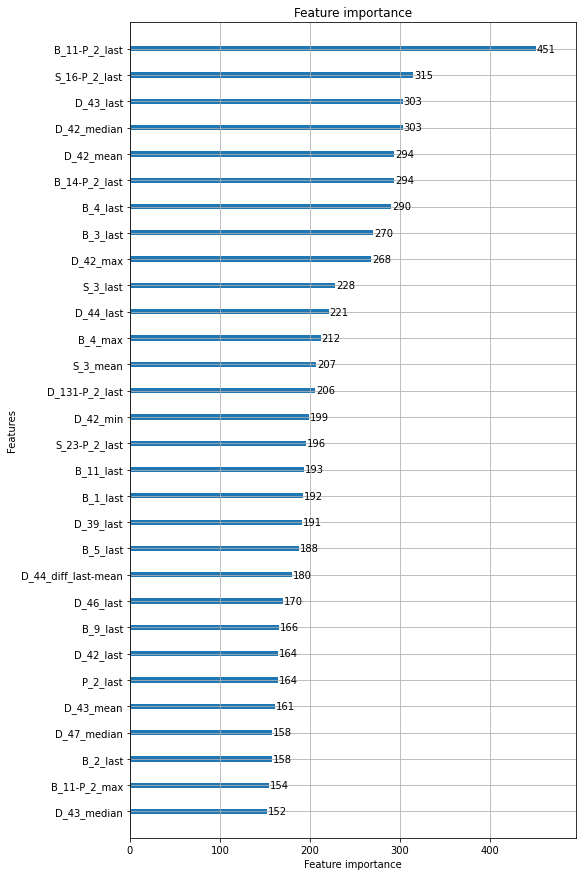

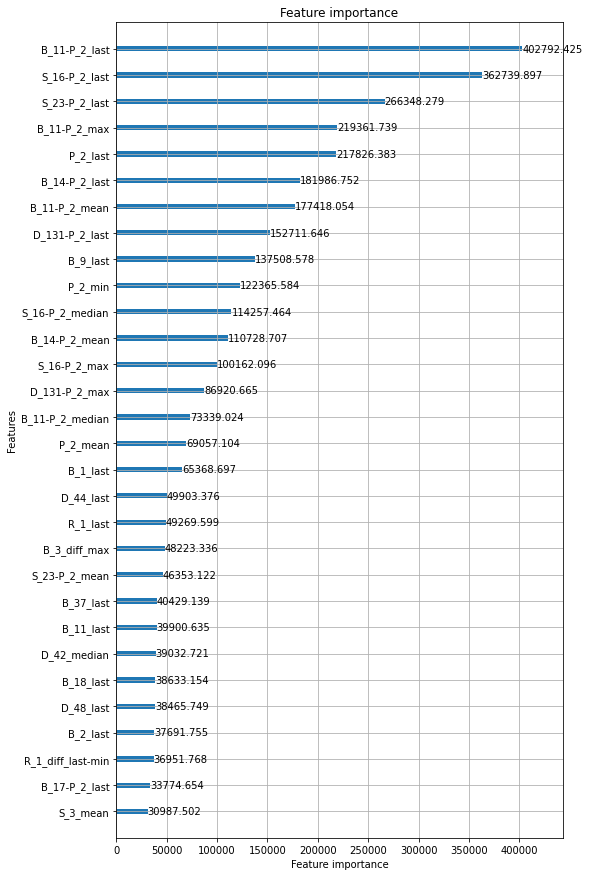

######################################## training model 3/5 ########################################
[50]	valid_0's amex_metric: 0.749913	valid_0's recall_at4: 0.601027	valid_0's norm_gini: 0.898799
[100]	valid_0's amex_metric: 0.762996	valid_0's recall_at4: 0.620887	valid_0's norm_gini: 0.905105
[150]	valid_0's amex_metric: 0.767784	valid_0's recall_at4: 0.626609	valid_0's norm_gini: 0.908959
[200]	valid_0's amex_metric: 0.774201	valid_0's recall_at4: 0.635614	valid_0's norm_gini: 0.912788
[250]	valid_0's amex_metric: 0.778884	valid_0's recall_at4: 0.642346	valid_0's norm_gini: 0.915422
[300]	valid_0's amex_metric: 0.781816	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.917163
[350]	valid_0's amex_metric: 0.783804	valid_0's recall_at4: 0.649163	valid_0's norm_gini: 0.918445
[400]	valid_0's amex_metric: 0.786834	valid_0's recall_at4: 0.654128	valid_0's norm_gini: 0.919541
[450]	valid_0's amex_metric: 0.787999	valid_0's recall_at4: 0.655685	valid_0's norm_gini: 0.920314
[500]	vali

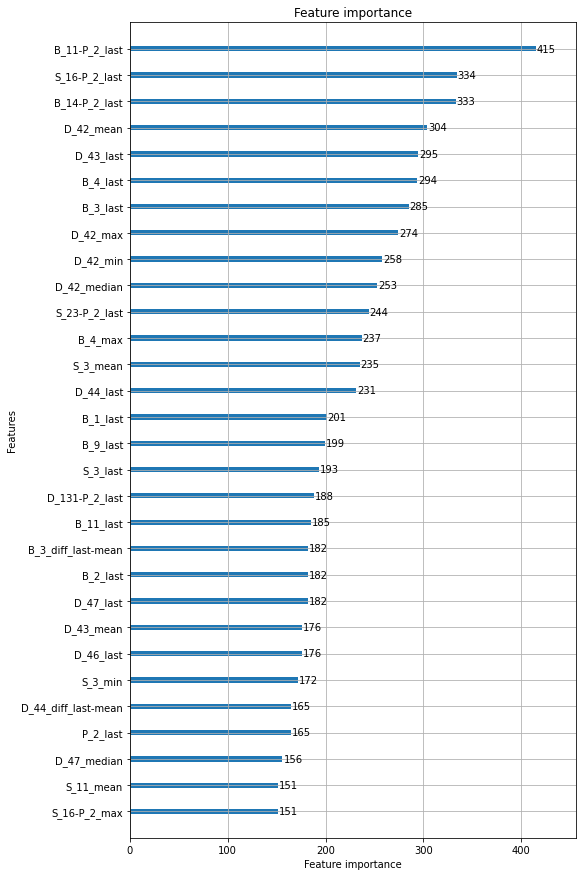

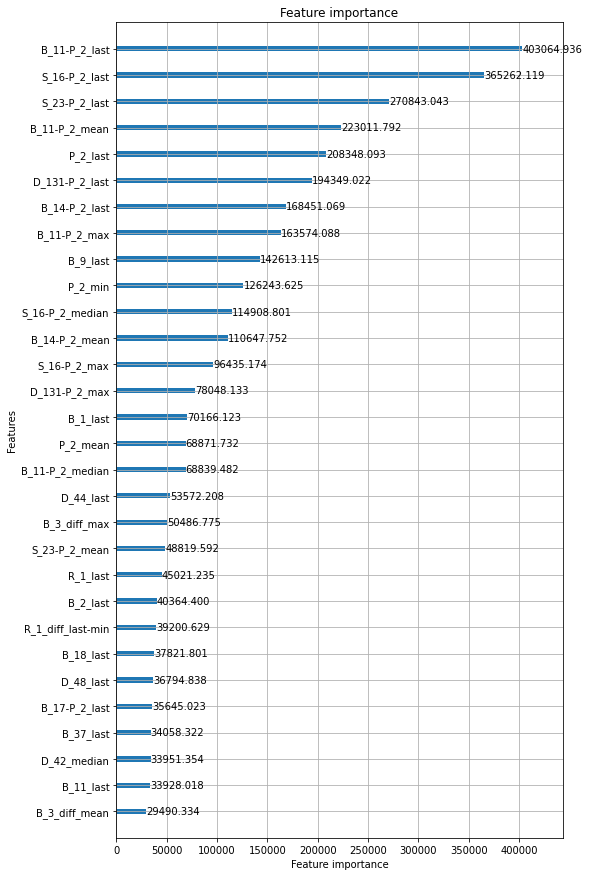

######################################## training model 4/5 ########################################
[50]	valid_0's amex_metric: 0.754662	valid_0's recall_at4: 0.606101	valid_0's norm_gini: 0.903222
[100]	valid_0's amex_metric: 0.764836	valid_0's recall_at4: 0.620871	valid_0's norm_gini: 0.908801
[150]	valid_0's amex_metric: 0.771834	valid_0's recall_at4: 0.631349	valid_0's norm_gini: 0.912319
[200]	valid_0's amex_metric: 0.777933	valid_0's recall_at4: 0.63968	valid_0's norm_gini: 0.916186
[250]	valid_0's amex_metric: 0.783421	valid_0's recall_at4: 0.648222	valid_0's norm_gini: 0.91862
[300]	valid_0's amex_metric: 0.786737	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.920245
[350]	valid_0's amex_metric: 0.789284	valid_0's recall_at4: 0.657017	valid_0's norm_gini: 0.921551
[400]	valid_0's amex_metric: 0.791198	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.92256
[450]	valid_0's amex_metric: 0.792329	valid_0's recall_at4: 0.661393	valid_0's norm_gini: 0.923266
[500]	valid_0

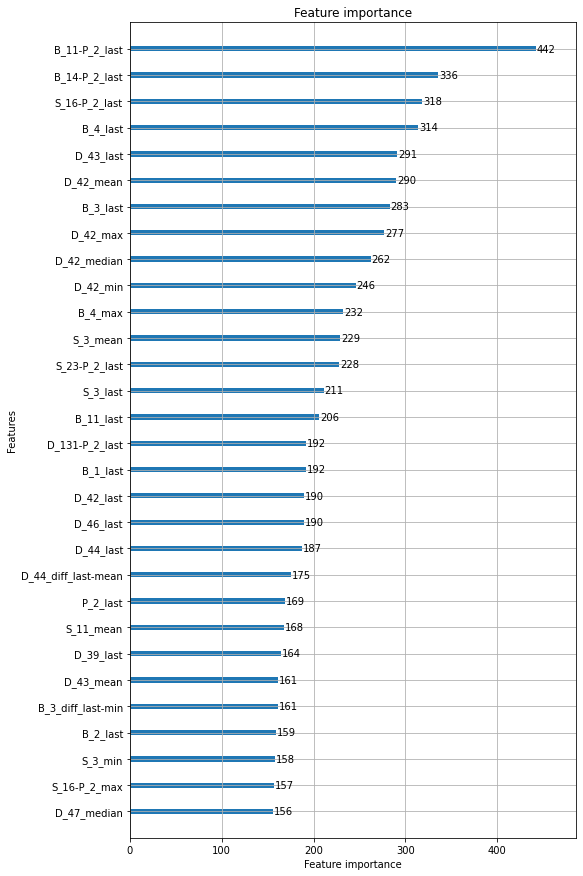

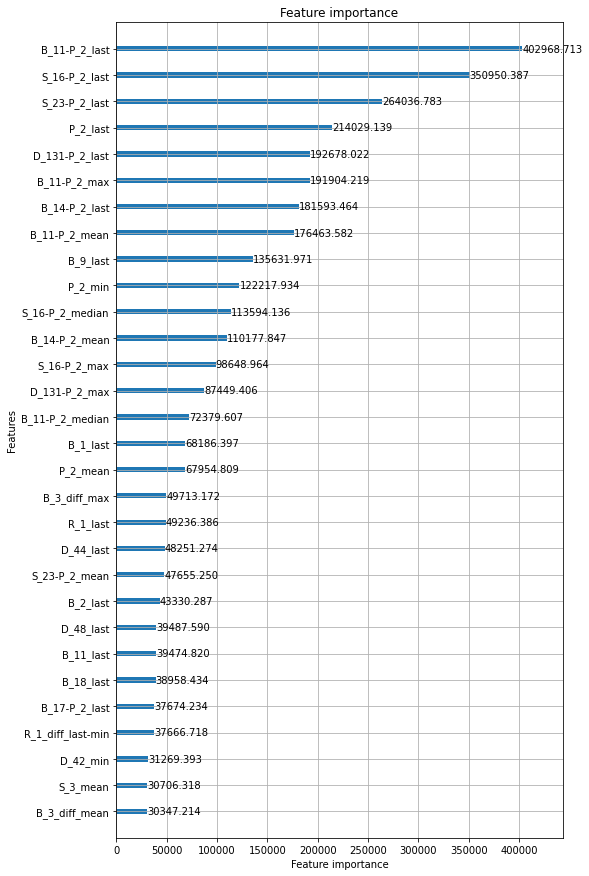

######################################## training model 5/5 ########################################
[50]	valid_0's amex_metric: 0.750456	valid_0's recall_at4: 0.601473	valid_0's norm_gini: 0.89944
[100]	valid_0's amex_metric: 0.761046	valid_0's recall_at4: 0.616789	valid_0's norm_gini: 0.905303
[150]	valid_0's amex_metric: 0.767622	valid_0's recall_at4: 0.626299	valid_0's norm_gini: 0.908944
[200]	valid_0's amex_metric: 0.773103	valid_0's recall_at4: 0.633579	valid_0's norm_gini: 0.912627
[250]	valid_0's amex_metric: 0.778689	valid_0's recall_at4: 0.642331	valid_0's norm_gini: 0.915047
[300]	valid_0's amex_metric: 0.782051	valid_0's recall_at4: 0.647465	valid_0's norm_gini: 0.916638
[350]	valid_0's amex_metric: 0.784386	valid_0's recall_at4: 0.650915	valid_0's norm_gini: 0.917857
[400]	valid_0's amex_metric: 0.786	valid_0's recall_at4: 0.653187	valid_0's norm_gini: 0.918813
[450]	valid_0's amex_metric: 0.787485	valid_0's recall_at4: 0.655418	valid_0's norm_gini: 0.919552
[500]	valid_0

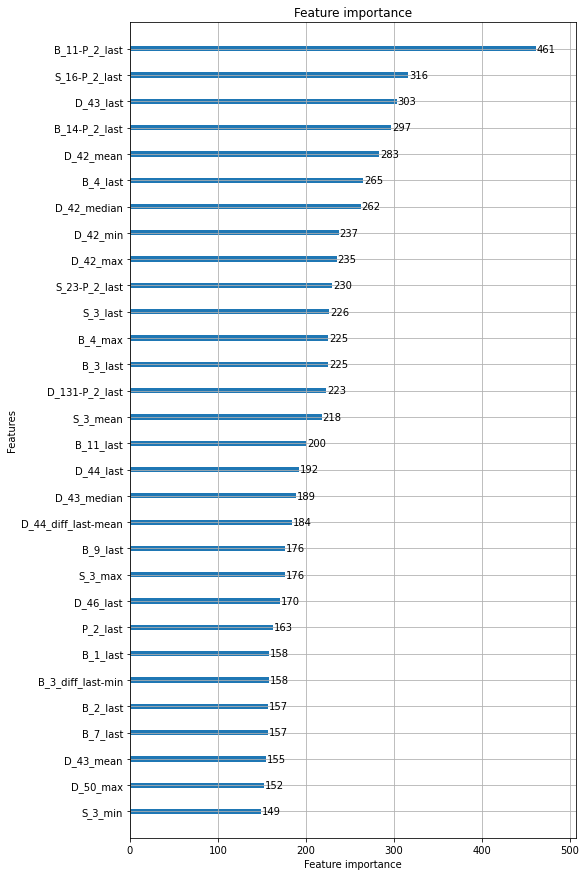

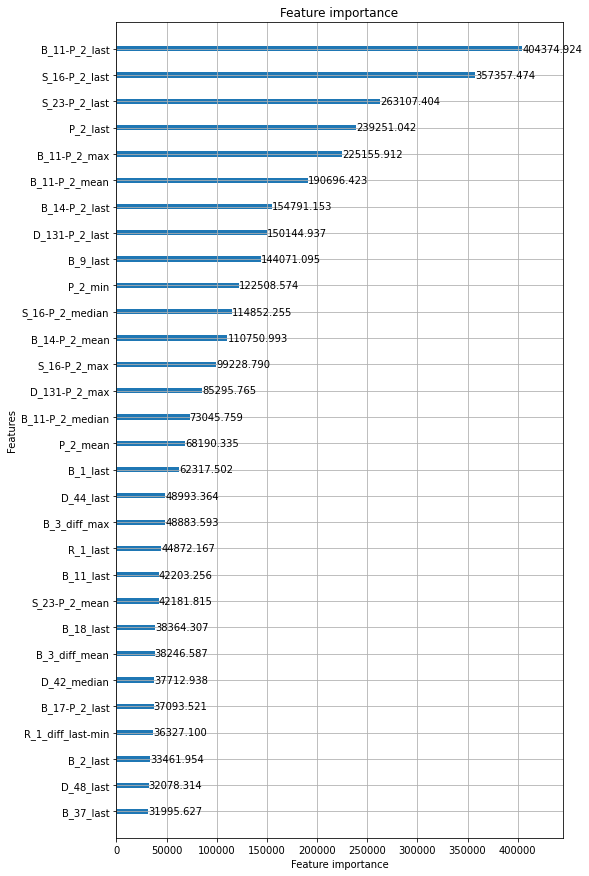

Training time: 86.71721045573553 min.
OOF recall_at4: 0.6703891338741711
OOF normalized_gini: 0.9260760001819748
OOF competition metric: 0.798232567028073
CPU times: user 1d 6h 32min 48s, sys: 1min 26s, total: 1d 6h 34min 14s
Wall time: 4h 19min 20s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.670574,0.926003,0.798289
1,0.671542,0.926053,0.798797
2,0.670389,0.926076,0.798233



mean:


recall_at4    0.670835
gini          0.926044
metric        0.798440
dtype: float64


std:


recall_at4    0.000619
gini          0.000037
metric        0.000311
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 1h 44min 10s, sys: 56.4 s, total: 1h 45min 6s
Wall time: 15min 23s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.55 s, sys: 798 ms, total: 4.35 s
Wall time: 4.34 s


***